In [1]:
import os
os.chdir("../")

In [2]:
import pickle
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn.functional as F
import numpy as np
from models.vt_resnet import vt_resnet18
from data_loaders.image_net import ImageNetDataset
from torch.utils.data import DataLoader, Subset
from pprint import pprint as pprint
import onnx

In [3]:
%load_ext autoreload
%autoreload 2

# Utility Functions

In [4]:
def store_params(content, name):
    f = open("params/" + name + ".pkl","wb")
    pickle.dump(content, f)
    f.close()

def load_params(name):
    fl = open("params/" + name + ".pkl", "rb")
    loaded = pickle.load(fl)
    return loaded

def list_params():
    
    params = []
    for p in os.listdir('./params'):
        params.append(p[:-4])
        
    return params

def show_image(img, one_channel=False, fig=(10,10), title='No Title'):
    if one_channel:
        img = img.mean(dim=0)
    img = img * 0.225 + 0.456     # unnormalize
    npimg = img.numpy()
    if one_channel:
        
        plt.figure(figsize = fig)
        plt.title(title)
        plt.imshow(npimg)
    else:
        plt.imshow(img)
        
        
def get_class(label, dataset):
    return dataset.class_index_to_name[label + 1]

# Reading Data

In [6]:
input_dim = 224
num_classes = 50

In [7]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((input_dim, input_dim))
    ])
train_dataset = ImageNetDataset(train=True, num_classes=num_classes, transform=transform)
valid_dataset = ImageNetDataset(train=False, num_classes=num_classes, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

In [8]:
model = onnx.load('trained_models/vt_resnet18_50cls_20ep_1e4lr.onnx')

In [ ]:
onnx.checker.check_model(model)

In [ ]:
import onnxruntime as ort

ort_session = ort.InferenceSession('trained_models/vt_resnet18_50cls_20ep_1e4lr.onnx')

outputs = ort_session.run(None, {'actual_input_1': np.random.randn(10, 3, 224, 224).astype(np.float32)})

print(outputs[0])

# Reading Model

In [9]:
def get_model(ID: int):
    params = load_params(f'attempt{ID}')
    model = vt_resnet18(
        pretrained=True,
        tokens=params['L'],
        token_channels=params['D'],
        input_dim=224,
        vt_channels=params['vt_channels'],
        transformer_enc_layers=params['enc_layer'],
        transformer_heads=params['n_head'],
        transformer_fc_dim=params['fc_dim'],
        transformer_dropout=params['dropout'],
        num_classes=20
    )
    state_dict = torch.load(f'./trained_models/attempt{ID}.pth', map_location=torch.device('cpu'))               
    model.load_state_dict(state_dict)
    model.eval()
    return model

In [10]:
def get_prediction(img, model):
    out = model(img)
    output = F.log_softmax(out, dim=1)
    _, pred = torch.max(output, dim=1)
    return get_class(pred.item(), valid_dataset)

# Visualizations

In [86]:
for p in list_params()[1:]:
    par = load_params(p)
    pprint(p)
    pprint(par)
    print("")
    
"""
L=12: 'attempt12'
L=8: 'attemtpt5'
L=16: 'attempt20'
"""

'attempt12'
{'D': 512,
 'L': 12,
 'N': 128,
 'dropout': 0.5,
 'enc_layer': 2,
 'fc_dim': 512,
 'lr': 0.0008,
 'n_head': 1,
 'optim': <class 'torch.optim.adam.Adam'>,
 'train_acc': tensor(95.2962),
 'valid_acc': tensor(73.8333),
 'vt_channels': 512,
 'vt_num_layer': 2}

'attempt17'
{'D': 512,
 'L': 16,
 'N': 128,
 'dropout': 0.5,
 'enc_layer': 2,
 'fc_dim': 512,
 'lr': 0.0008,
 'n_head': 1,
 'optim': <class 'torch.optim.adam.Adam'>,
 'train_acc': tensor(90.3851),
 'valid_acc': tensor(77.),
 'vt_channels': 512,
 'vt_num_layer': 1}

'param_c_10_lr_002'
{'D': 1024,
 'L': 16,
 'N': 128,
 'dropout': 0.5,
 'enc_layer': 2,
 'fc_dim': 1024,
 'lr': 0.002,
 'n_head': 1,
 'optim': <class 'torch.optim.adam.Adam'>,
 'train_acc': tensor(96.7160),
 'valid_acc': tensor(86.),
 'vt_channels': 512,
 'vt_num_layer': 2}

'attempt5'
{'D': 512,
 'L': 8,
 'N': 128,
 'dropout': 0.5,
 'enc_layer': 2,
 'fc_dim': 512,
 'lr': 0.0008,
 'n_head': 1,
 'optim': <class 'torch.optim.adam.Adam'>,
 'train_acc': tensor(95.1

In [11]:
by_class = {}

for i in range(num_classes):
    by_class[i] = []
    
for data in valid_loader:
    img, label = data
    by_class[label.item()].append(img)

[get_class(k, valid_dataset) for k in by_class.keys()]

/kuacc/users/nnayal17/.conda/envs/nazir_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


['kit_fox',
 'English_setter',
 'Siberian_husky',
 'Australian_terrier',
 'English_springer',
 'grey_whale',
 'lesser_panda',
 'Egyptian_cat',
 'ibex',
 'Persian_cat',
 'cougar',
 'gazelle',
 'porcupine',
 'sea_lion',
 'malamute',
 'badger',
 'Great_Dane',
 'Walker_hound',
 'Welsh_springer_spaniel',
 'whippet']

# 8 Tokens

In [12]:
model1 = get_model(5)

In [25]:
cls1 = 7
idx1 = 1

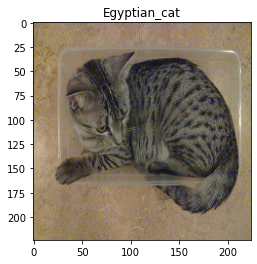

In [26]:
plt.title(get_prediction(by_class[cls1][idx1], model1))
plt.imshow(by_class[cls1][idx1][0].permute(1, 2, 0))

In [15]:
get_prediction(by_class[cls1][idx1], model1)

'kit_fox'

In [16]:
get_prediction(by_class[cls1][idx1], model1)

'kit_fox'

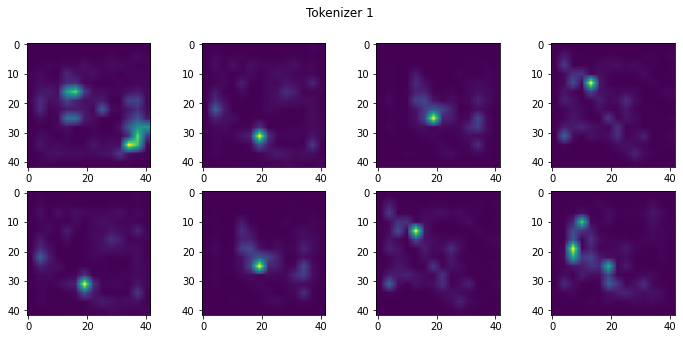

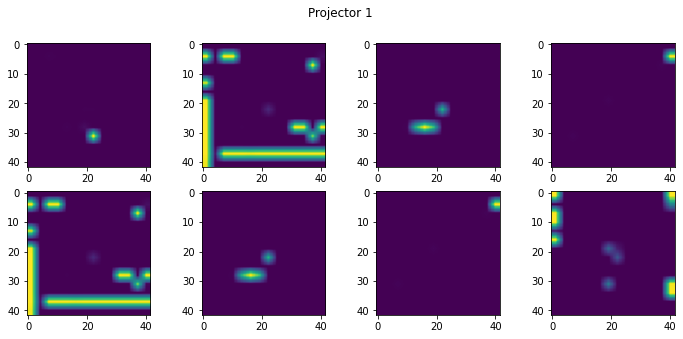

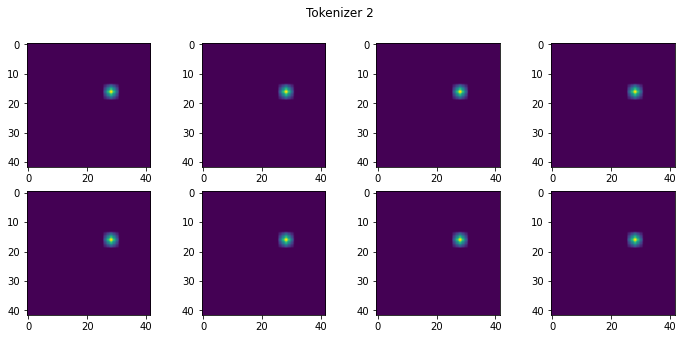

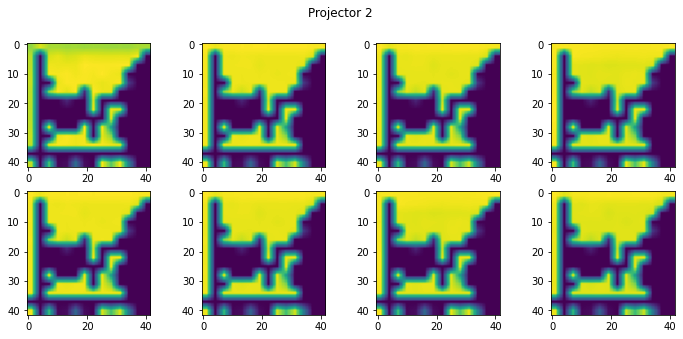

In [27]:
for i in range(model1.vt_layers_num):
    cache = model1.vt_layers[i].tokenizer.cache2
    cache = torch.transpose(cache, 1, 2)
    with torch.no_grad():
        pic = cache[0].reshape(8, 1, 14, 14)
        pic = F.interpolate(pic, scale_factor=3, mode='bilinear')
        #show_image(torchvision.utils.make_grid(pic, nrow=4), True, fig=(10,10), title='Tokenizer Layer ' + str(i + 1))
        fig, ax = plt.subplots(2, 4, figsize=(12, 5))
        for k1 in range(2):
            for k2 in range(4):
                ax[k1][k2].imshow(pic[k1 + k2].permute(1, 2, 0))
        fig.suptitle(f"Tokenizer {i + 1}")
        
    pr_cache1 = model1.vt_layers[i].projector.cache
    pr_cache1 = torch.transpose(pr_cache1, 1, 2)
    pr_cache1 = torch.transpose(pr_cache1, 0, 1)

    with torch.no_grad():
        pic = pr_cache1.reshape(8, 1, 14, 14)
        pic = F.interpolate(pic, scale_factor=3, mode='bilinear')
        fig, ax = plt.subplots(2, 4, figsize=(12, 5))
        for k1 in range(2):
            for k2 in range(4):
                ax[k1][k2].imshow(pic[k1 + k2].permute(1, 2, 0))
        fig.suptitle(f"Projector {i + 1}")
        #show_image(torchvision.utils.make_grid(pic, nrow=4), True, fig=(10,10), title='Projector Layer 1')
    

# 12 Tokens

In [25]:
model2 = get_model(12)

In [26]:
cls2 = 0
idx2 = 1

In [ ]:
print(get_class(cls2, valid_dataset))
plt.imshow(by_class[cls2][idx2][0].permute(1, 2, 0))

In [ ]:
get_prediction(by_class[cls2][idx2], model2)

In [ ]:
get_prediction(by_class[cls2][idx2], model2)

In [ ]:
for i in range(model2.vt_layers_num):
    cache = model2.vt_layers[i].tokenizer.cache2
    cache = torch.transpose(cache, 1, 2)
    with torch.no_grad():
        pic = cache[0].reshape(12, 1, 14, 14)
        pic = F.interpolate(pic, scale_factor=3, mode='bilinear')
        #show_image(torchvision.utils.make_grid(pic, nrow=4), True, fig=(10,10), title='Tokenizer Layer ' + str(i + 1))
        fig, ax = plt.subplots(3, 4, figsize=(20, 15))
        for k1 in range(3):
            for k2 in range(4):
                ax[k1][k2].imshow(pic[k1 + k2].permute(1, 2, 0))
        fig.suptitle(f"Tokenizer {i + 1}")
        
    pr_cache1 = model.vt_layers[i].projector.cache
    pr_cache1 = torch.transpose(pr_cache1, 1, 2)
    pr_cache1 = torch.transpose(pr_cache1, 0, 1)

    with torch.no_grad():
        pic = pr_cache1.reshape(12, 1, 14, 14)
        pic = F.interpolate(pic, scale_factor=3, mode='bilinear')
        fig, ax = plt.subplots(3, 4, figsize=(20, 15))
        for k1 in range(3):
            for k2 in range(4):
                ax[k1][k2].imshow(pic[k1 + k2].permute(1, 2, 0))
        fig.suptitle(f"Projector {i + 1}")
        #show_image(torchvision.utils.make_grid(pic, nrow=4), True, fig=(10,10), title='Projector Layer 1')
    

# 16 Tokens

In [92]:
model3 = get_model(20)

In [89]:
cls3 = 0
idx3 = 1

kit_fox


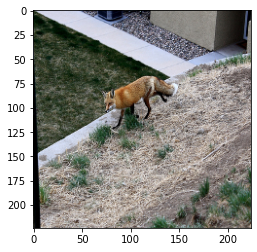

In [90]:
print(get_class(cls3, valid_dataset))
plt.imshow(by_class[cls3][idx3][0].permute(1, 2, 0))

In [93]:
get_prediction(by_class[cls3][idx3], model3)

'ibex'

In [80]:
get_prediction(by_class[cls3][idx3], model3)

'English_setter'

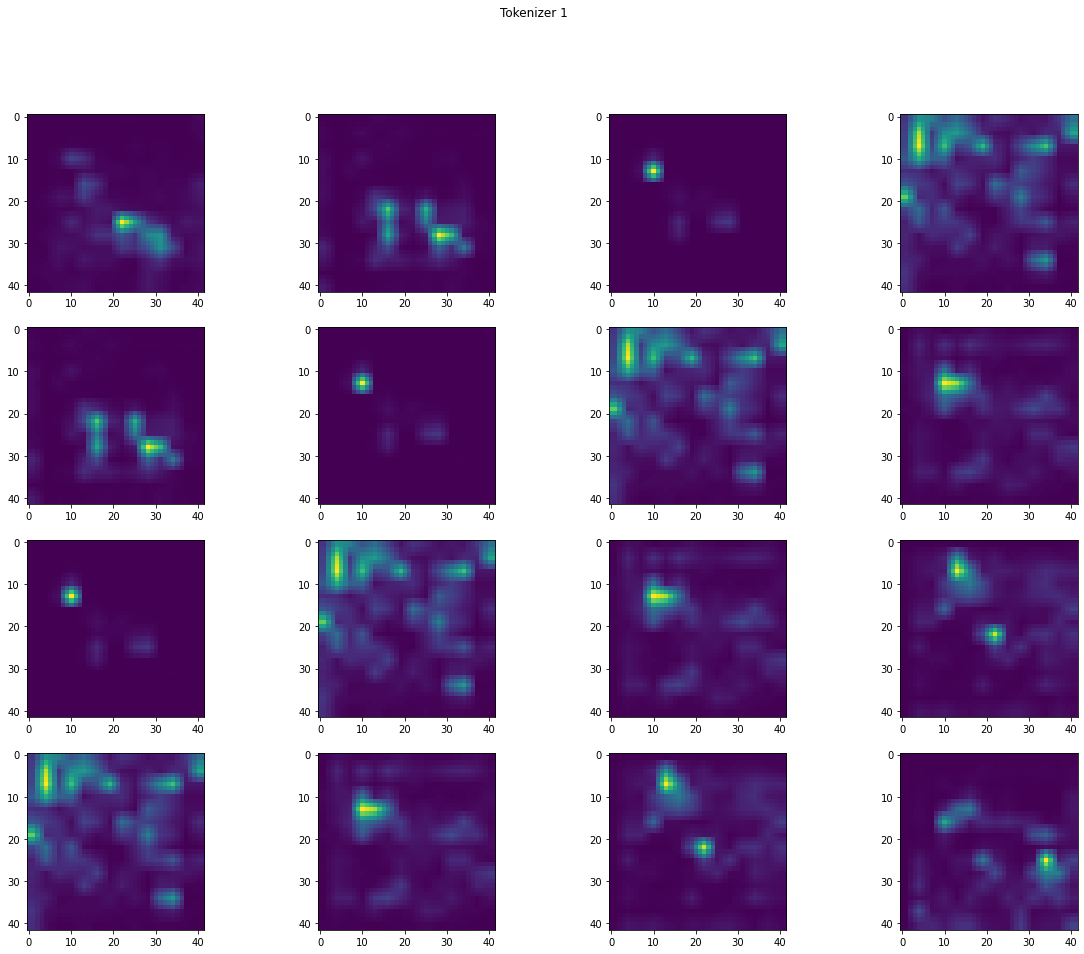

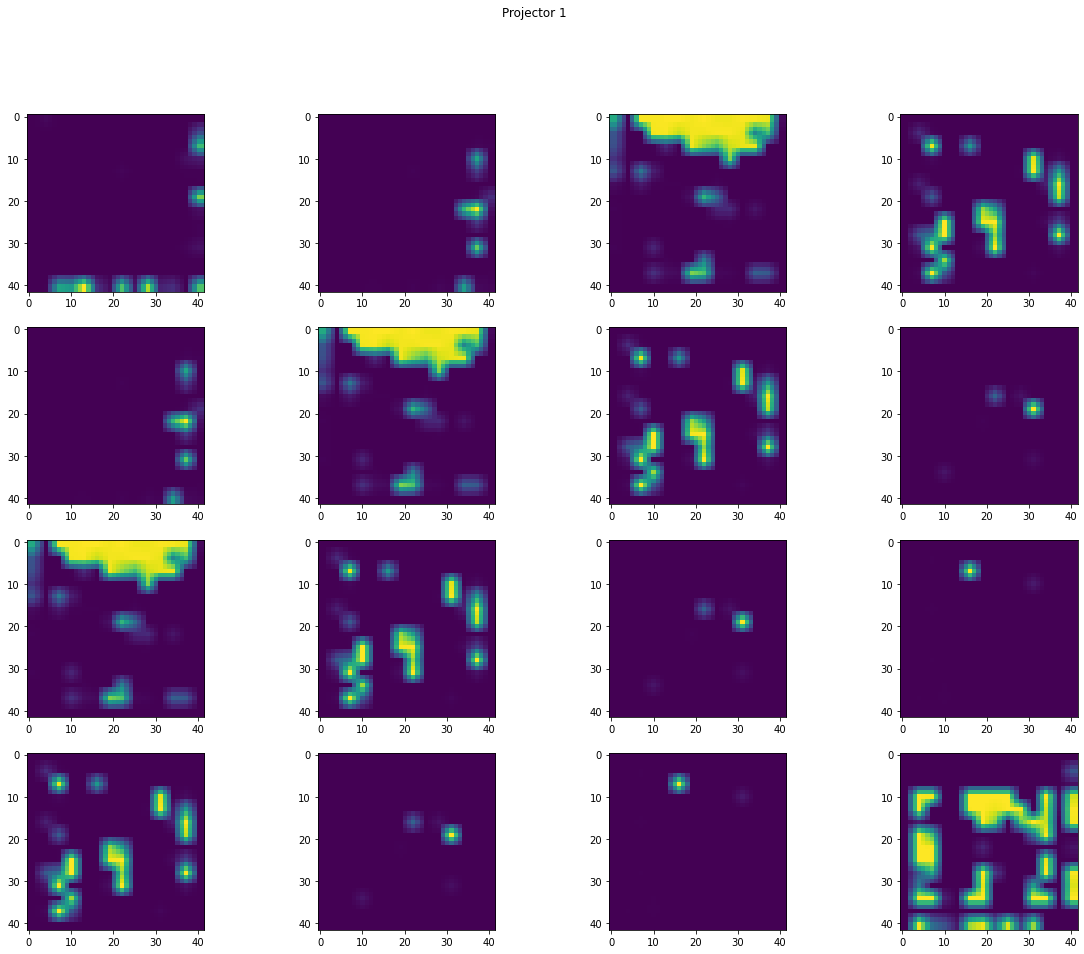

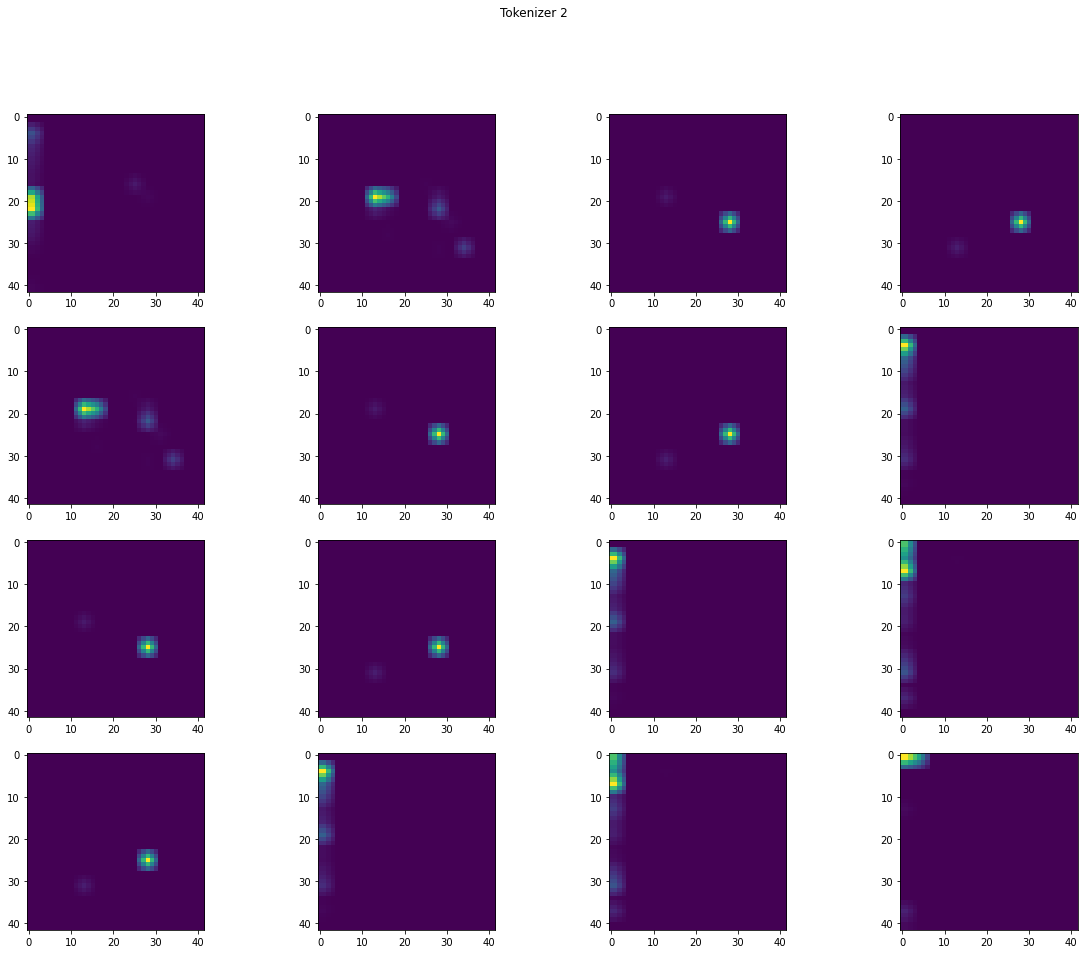

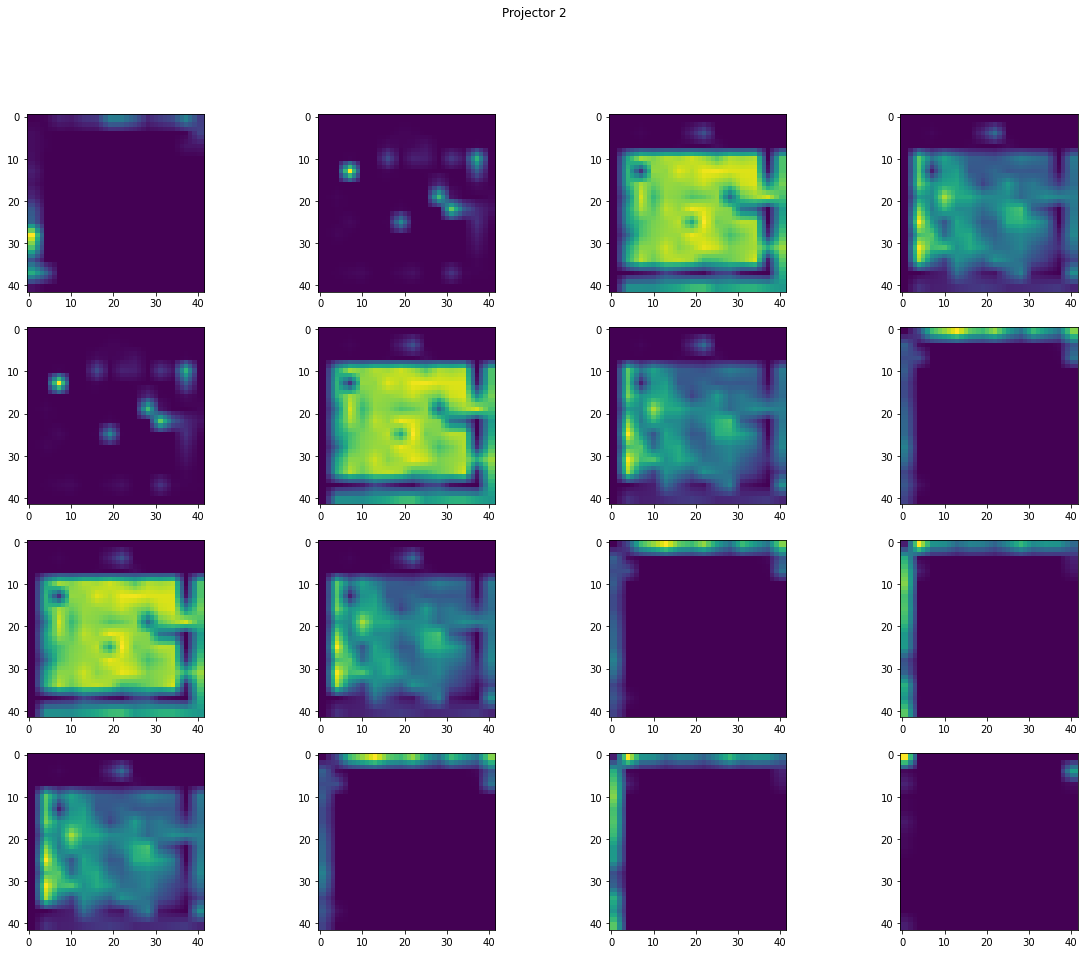

In [111]:
for i in range(model3.vt_layers_num):
    cache = model.vt_layers[i].tokenizer.cache2
    cache = torch.transpose(cache, 1, 2)
    with torch.no_grad():
        pic = cache[0].reshape(16, 1, 14, 14)
        pic = F.interpolate(pic, scale_factor=3, mode='bilinear')
        #show_image(torchvision.utils.make_grid(pic, nrow=4), True, fig=(10,10), title='Tokenizer Layer ' + str(i + 1))
        fig, ax = plt.subplots(4, 4, figsize=(20, 15))
        for k1 in range(4):
            for k2 in range(4):
                ax[k1][k2].imshow(pic[k1 + k2].permute(1, 2, 0))
        fig.suptitle(f"Tokenizer {i + 1}")
        
    pr_cache1 = model.vt_layers[i].projector.cache
    pr_cache1 = torch.transpose(pr_cache1, 1, 2)
    pr_cache1 = torch.transpose(pr_cache1, 0, 1)

    with torch.no_grad():
        pic = pr_cache1.reshape(16, 1, 14, 14)
        pic = F.interpolate(pic, scale_factor=3, mode='bilinear')
        fig, ax = plt.subplots(4, 4, figsize=(20, 15))
        for k1 in range(4):
            for k2 in range(4):
                ax[k1][k2].imshow(pic[k1 + k2].permute(1, 2, 0))
        fig.suptitle(f"Projector {i + 1}")
        #show_image(torchvision.utils.make_grid(pic, nrow=4), True, fig=(10,10), title='Projector Layer 1')
    